<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-Data-/-データの読み込み" data-toc-modified-id="Input-Data-/-データの読み込み-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input Data / データの読み込み</a></span></li><li><span><a href="#Define-Function-/-関数定義" data-toc-modified-id="Define-Function-/-関数定義-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Function / 関数定義</a></span></li><li><span><a href="#準備：項目を並べる順番を決め、必要ない項目名を除外する" data-toc-modified-id="準備：項目を並べる順番を決め、必要ない項目名を除外する-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>準備：項目を並べる順番を決め、必要ない項目名を除外する</a></span></li><li><span><a href="#デフォルトは、p値と、下三角行列のみ出力" data-toc-modified-id="デフォルトは、p値と、下三角行列のみ出力-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>デフォルトは、p値と、下三角行列のみ出力</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#保存" data-toc-modified-id="保存-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>保存</a></span></li></ul></li><li><span><a href="#p値を数字で表示する(pval=&quot;&quot;)場合" data-toc-modified-id="p値を数字で表示する(pval=&quot;&quot;)場合-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>p値を数字で表示する(pval="")場合</a></span><ul class="toc-item"><li><span><a href="#保存" data-toc-modified-id="保存-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>保存</a></span></li></ul></li><li><span><a href="#対角線の相関係数1も表示したい時(***は表示しない)" data-toc-modified-id="対角線の相関係数1も表示したい時(***は表示しない)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>対角線の相関係数1も表示したい時(***は表示しない)</a></span><ul class="toc-item"><li><span><a href="#保存" data-toc-modified-id="保存-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>保存</a></span></li></ul></li><li><span><a href="#下三角ではなく、両サイド出力したい(triangular='')時。" data-toc-modified-id="下三角ではなく、両サイド出力したい(triangular='')時。-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>下三角ではなく、両サイド出力したい(triangular='')時。</a></span><ul class="toc-item"><li><span><a href="#保存" data-toc-modified-id="保存-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>保存</a></span></li></ul></li></ul></li><li><span><a href="#欠損処理について" data-toc-modified-id="欠損処理について-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>欠損処理について</a></span></li></ul></div>

# 基本統計・相関係数と有意差出力プログラム
**本プログラムは、データフレームを入れると、論文等の「各変数の記述統計量および相関」「記述統計量と相関分析」や
"Means, Standard Deviations, and Intercorrelations", "Correlations among main variables", "Intercorrelations between Variables"のTableに記載するためのcsvを自動で吐き出すプログラムである。**
なお、クロンバック(chronbach)のαについては算出しない。Inputでは、下位因子がある場合は、１カラムに下位因子の平均値等の最終的な値が既に計算されている必要がある。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


## Input Data / データの読み込み

In [2]:
filename = "https://raw.githubusercontent.com/ryouen/corr_matrix/main/sample_dataframe.csv"
df=pd.read_csv(filename,skiprows=0)
df

,ID,gender,age,Engagement,Creativity,PsySafety,Trust,Happiness,Others
0,1,男性,20,5,2,4.0,5.0,5.0,3.0
1,2,女性,22,5,1,2.0,5.0,5.0,3.0
2,3,女性,22,3,1,3.0,5.0,4.0,1.0
3,4,男性,22,5,3,5.0,5.0,5.0,5.0
4,5,女性,23,5,4,5.0,5.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...
495,496,男性,63,3,4,3.0,NaN,5.0,3.0
496,497,男性,63,3,4,NaN,NaN,4.0,3.0
497,498,男性,64,4,4,4.0,NaN,NaN,NaN
498,499,男性,64,3,4,4.0,NaN,4.0,3.0


**<a href="https://colab.research.google.com/drive/">Google Colab</a> を利用し、自分のファイルをアップロードする場合は、次のセルのコメントアウトを外して、ファイルをGoogle Colabにアップロードできるようにする。**

In [3]:
#from google.colab import files
#uploaded = files.upload()
#filename = list(uploaded.keys())[0]
#df=pd.read_csv(filename,skiprows=0)
#df

## Define Function / 関数定義

In [4]:
lst = df.columns.to_list()

In [5]:
def describe_corr_func(df, pval="*", triangular='TRUE', ones=''):
    
    # カラムに、相関が取れない文字列型等が含まれていないかをチェック。
    for i in lst:
        if df[i].dtype=='object':
            lst.remove(i)
            print(i,'は、object型のため、表示から除外します')
    print(lst)

    # p値を表示するためにカラム名に'_p'を順番につける
    lst_all = []
    for item in lst:
        lst_all = lst_all + [item]
        lst_all = lst_all + [item+'_p']
#    print(lst_all)
    df_describe = pd.DataFrame(columns=lst_all, index=lst)
    for i in lst:
        for j in lst:
            if triangular!='':
                if ((ones=='') and (i == j)):
                    break
            df2 = df.dropna(subset=[i, j])
            x, y = df2[i], df2[j]
#            print(stats.pearsonr(x, y)[0])
            df_describe.at[i,j] = stats.pearsonr(x, y)[0]
            jp = j + '_p'
            if pval=="*":
                if stats.pearsonr(x, y)[1] < 0.001:
                    df_describe.at[i,jp] = '***'
                elif stats.pearsonr(x, y)[1] < 0.01:
                    df_describe.at[i,jp] = '**'
                elif stats.pearsonr(x, y)[1] < 0.05:
                    df_describe.at[i,jp] = '*'
                # '+' 記号が必要な場合は、次の２行のコメントアウトを除外するする
                #elif stats.pearsonr(x, y)[1] < 0.1: 
                #    df_describe.at[i,jp] = '+'
                else:
                    df_describe.at[i,jp] = ''
            else:
                df_describe.at[i,jp] = stats.pearsonr(x, y)[1]
            #三角行列にする
            if triangular=='TRUE':
                if i==j:
                    break
    
    df_trans = df.describe().transpose()[['count','mean','std']]
    df_describe = pd.concat([df_trans, df_describe], axis=1, join='inner')

    if pval=="*":
        print('注：*** p < .001, ** p < .01, * p < .05, + p < .10')

    return df_describe.reindex(index=lst, columns=['count','mean','std']+lst_all)
            

# 運用

## 準備：項目を並べる順番を決め、必要ない項目名を除外する

In [6]:
df.columns.to_list()

['ID',
 'gender',
 'age',
 'Engagement',
 'Creativity',
 'PsySafety',
 'Trust',
 'Happiness',
 'Others']

**次のリストに入れた順序で、項目が出力される**

In [7]:
#このケースでは、ID, gender, Othersの３カラムを除外し、下記の順番で出力を期待している。
lst = [#'ID', 'gender',
 'age', 'Engagement', 'Creativity', 'PsySafety', 'Trust', 'Happiness',
    #'Others'
    ]


**p値出力の有無・３角行列の左下のみ出力の有無を設定できる**

|オプション|default|結果|
|-|-|-|
|pval="*"|YES|p値を記号で出力する|
|pval=""|-|p値を数値で出力する|
|triangular='TRUE'|YES|下三角行列のみ出力する|
|triangular=''|-|三角行列ではなく、すべて出力する|
|ones=''|YES|対角線の1を出力しない|
|ones='1'|-|対角線の1を出力する|



## デフォルトは、p値と、下三角行列のみ出力

In [8]:
df_describe = describe_corr_func(df[lst])
df_describe


['age', 'Engagement', 'Creativity', 'PsySafety', 'Trust', 'Happiness']
注：*** p < .001, ** p < .01, * p < .05, + p < .10


,count,mean,std,age,age_p,Engagement,Engagement_p,Creativity,Creativity_p,PsySafety,PsySafety_p,Trust,Trust_p,Happiness,Happiness_p
age,500.0,42.718000,10.818714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engagement,500.0,3.558000,0.986195,-0.313734,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creativity,500.0,3.556000,0.953248,0.235399,***,0.125507,**,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PsySafety,495.0,3.662626,1.028598,0.0846954,,0.0635271,,0.134931,**,NaN,NaN,NaN,NaN,NaN,NaN
Trust,467.0,4.094218,0.758152,-0.0682214,,0.178254,***,0.189594,***,0.253031,***,NaN,NaN,NaN,NaN
Happiness,494.0,4.058704,0.877135,-0.137718,**,0.406368,***,0.198513,***,0.322406,***,0.461458,***,NaN,NaN


#### 保存

In [9]:
df_describe.to_csv('df_describe_p.csv',index=True, encoding='utf_8_sig')

### p値を数字で表示する(pval="")場合


In [10]:
df_describe = describe_corr_func(df[lst], pval="")
df_describe

['age', 'Engagement', 'Creativity', 'PsySafety', 'Trust', 'Happiness']


,count,mean,std,age,age_p,Engagement,Engagement_p,Creativity,Creativity_p,PsySafety,PsySafety_p,Trust,Trust_p,Happiness,Happiness_p
age,500.0,42.718000,10.818714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engagement,500.0,3.558000,0.986195,-0.313734,6.98122e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creativity,500.0,3.556000,0.953248,0.235399,1.00665e-07,0.125507,0.00494607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PsySafety,495.0,3.662626,1.028598,0.0846954,0.059704,0.0635271,0.158173,0.134931,0.00262805,NaN,NaN,NaN,NaN,NaN,NaN
Trust,467.0,4.094218,0.758152,-0.0682214,0.14101,0.178254,0.000107579,0.189594,3.72919e-05,0.253031,3.39119e-08,NaN,NaN,NaN,NaN
Happiness,494.0,4.058704,0.877135,-0.137718,0.00215639,0.406368,4.57224e-21,0.198513,8.77613e-06,0.322406,2.72683e-13,0.461458,9.64143e-26,NaN,NaN


#### 保存

In [11]:
df_describe.to_csv('df_describe_pval.csv',index=True, encoding='utf_8_sig')

### 対角線の相関係数1も表示したい時(***は表示しない)

In [12]:
df_describe = describe_corr_func(df[lst],ones='1')
df_describe

['age', 'Engagement', 'Creativity', 'PsySafety', 'Trust', 'Happiness']
注：*** p < .001, ** p < .01, * p < .05, + p < .10


,count,mean,std,age,age_p,Engagement,Engagement_p,Creativity,Creativity_p,PsySafety,PsySafety_p,Trust,Trust_p,Happiness,Happiness_p
age,500.0,42.718000,10.818714,1,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engagement,500.0,3.558000,0.986195,-0.313734,***,1,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creativity,500.0,3.556000,0.953248,0.235399,***,0.125507,**,1,***,NaN,NaN,NaN,NaN,NaN,NaN
PsySafety,495.0,3.662626,1.028598,0.0846954,,0.0635271,,0.134931,**,1,***,NaN,NaN,NaN,NaN
Trust,467.0,4.094218,0.758152,-0.0682214,,0.178254,***,0.189594,***,0.253031,***,1,***,NaN,NaN
Happiness,494.0,4.058704,0.877135,-0.137718,**,0.406368,***,0.198513,***,0.322406,***,0.461458,***,1,***


#### 保存

In [13]:
df_describe.to_csv('df_describe_p_1s.csv',index=True, encoding='utf_8_sig')

### 下三角ではなく、両サイド出力したい(triangular='')時。
**対角線の1は(ones='')オプションを入れても強制表示**

In [14]:
df_describe = describe_corr_func(df[lst],triangular='', ones='')
df_describe

['age', 'Engagement', 'Creativity', 'PsySafety', 'Trust', 'Happiness']
注：*** p < .001, ** p < .01, * p < .05, + p < .10


,count,mean,std,age,age_p,Engagement,Engagement_p,Creativity,Creativity_p,PsySafety,PsySafety_p,Trust,Trust_p,Happiness,Happiness_p
age,500.0,42.718000,10.818714,1,***,-0.313734,***,0.235399,***,0.0846954,,-0.0682214,,-0.137718,**
Engagement,500.0,3.558000,0.986195,-0.313734,***,1,***,0.125507,**,0.0635271,,0.178254,***,0.406368,***
Creativity,500.0,3.556000,0.953248,0.235399,***,0.125507,**,1,***,0.134931,**,0.189594,***,0.198513,***
PsySafety,495.0,3.662626,1.028598,0.0846954,,0.0635271,,0.134931,**,1,***,0.253031,***,0.322406,***
Trust,467.0,4.094218,0.758152,-0.0682214,,0.178254,***,0.189594,***,0.253031,***,1,***,0.461458,***
Happiness,494.0,4.058704,0.877135,-0.137718,**,0.406368,***,0.198513,***,0.322406,***,0.461458,***,1,***


#### 保存

In [15]:
df_describe.to_csv('df_describe_p_both.csv',index=True, encoding='utf_8_sig')

# 検証・補足事項
**通常に相関係数をとったものと比較してみるとよい**

In [16]:
df[lst].corr()

,age,Engagement,Creativity,PsySafety,Trust,Happiness
age,1.000000,-0.313734,0.235399,0.084695,-0.068221,-0.137718
Engagement,-0.313734,1.000000,0.125507,0.063527,0.178254,0.406368
Creativity,0.235399,0.125507,1.000000,0.134931,0.189594,0.198513
PsySafety,0.084695,0.063527,0.134931,1.000000,0.253031,0.322406
Trust,-0.068221,0.178254,0.189594,0.253031,1.000000,0.461458
Happiness,-0.137718,0.406368,0.198513,0.322406,0.461458,1.000000


C:\Users\ryosu\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ryosu\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


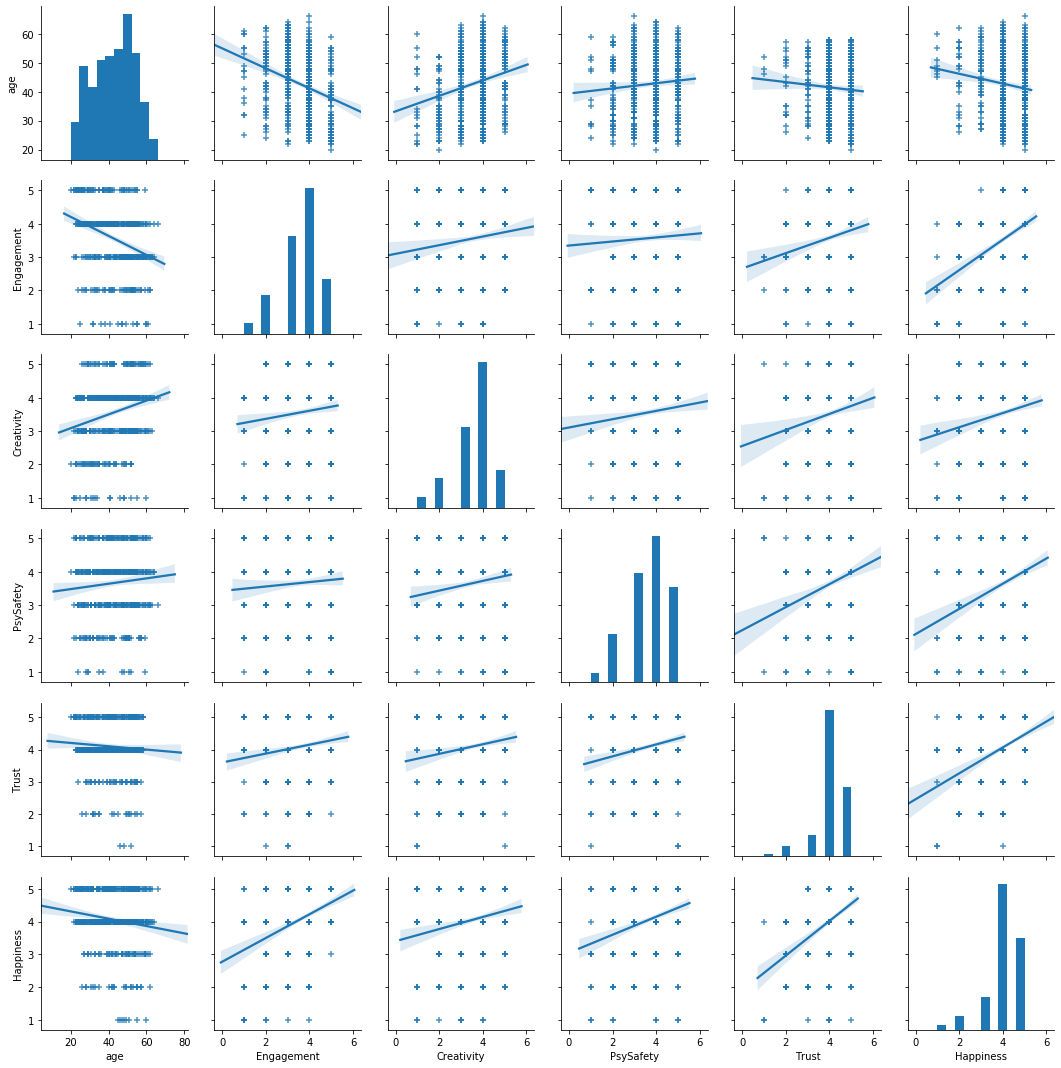

In [17]:
g = sns.pairplot(df, vars=lst, kind="reg", markers="+")
#g.set(xlim=(1, 5), ylim=(1, 5), xticks=[1, 3, 5], yticks=[1, 3, 5])


## 欠損処理について
**基本的には、２列を比較する際、どちらか片方に欠損がある情報を除外し,ピアソン積率相関係数を計算している**

In [18]:

x, y = df[['Engagement','Creativity']].dropna()['Engagement'], df[['Engagement','Creativity']].dropna()['Creativity']
stats.pearsonr(x, y) #ピアソン積率相関係数。


(0.1255073078179289, 0.004946065147023796)

In [19]:
# もし、object型のエラーが出た場合、下記のように{'元となるテキスト':数値}のように変換が可能
df['gender'].replace({'男性':0, '女性':1},inplace=True)
   

# アウトプット・整形

<a href="https://github.com/ryouen/corr_matrix/blob/main/Final_Output_Sample.xlsx?raw=true">Final_Output_Sample.xlsx</a>を参照して、出力したcsvファイルをコピペしてください。


# 作者について

石井 遼介（いしい りょうすけ）

<a href="https://twitter.com/ryouen">Twitter: @ryouen はこちら</a>

<a href="https://amzn.to/3BDWhiT">書籍『心理的安全性のつくりかた』はこちら</a>
